# Geo Embeddings

Notebook to apply different embeddings to represent h3 cells

@roman

24 / 3 / 25

---
# Settings

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import h3
import os
import networkx as nx
from node2vec import Node2Vec
from sklearn.manifold import TSNE

from INEGIpy import MarcoGeoestadistico

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# settings
pd.options.display.max_columns = 120
geo_framework = MarcoGeoestadistico()

# params
HEX_RESOLUTION = 9

---
# Data

## Read

### Inegi


In [3]:
# get all mexico states
gdf_mex_states = geo_framework.Entidades()
gdf_mex_states.head()

,geometry,cvegeo,cve_agee,nom_agee,nom_abrev,pob,pob_fem,pob_mas,viv
0,"MULTIPOLYGON (((-102.29739 22.45527, -102.2955...",01,01,Aguascalientes,Ags.,1425607,728924,696683,386671
1,"MULTIPOLYGON (((-114.11561 28.09639, -114.1152...",02,02,Baja California,BC,3769020,1868431,1900589,1149563
2,"MULTIPOLYGON (((-109.89451 22.87476, -109.8946...",03,03,Baja California Sur,BCS,798447,392568,405879,240660
3,"MULTIPOLYGON (((-91.95650 20.19700, -91.95636 ...",04,04,Campeche,Camp.,928363,471424,456939,260824
4,"MULTIPOLYGON (((-102.31549 29.88000, -102.3150...",05,05,Coahuila de Zaragoza,Coah.,3146771,1583102,1563669,901249


### Hexagons

In [4]:
# hex_id to lat/lon
def hex_to_lat_lon(hex_id):
    lat, lon = h3.h3_to_geo(hex_id)
    return lat, lon

# vectorize function
v_hex_to_lat_lon = np.vectorize(hex_to_lat_lon)

In [5]:
# read hex
gdf_terrain_prices = pd.read_parquet("../../data/misc/terrain_prices.parquet")

# to lat/lon
gdf_terrain_prices["latitude"], gdf_terrain_prices["longitude"] = v_hex_to_lat_lon(gdf_terrain_prices["hex_id"])

# to geodataframe
gdf_terrain_prices = gpd.GeoDataFrame(
    gdf_terrain_prices, 
    geometry=gpd.points_from_xy(gdf_terrain_prices["longitude"], gdf_terrain_prices["latitude"]),
    crs="EPSG:4326"
)

# look
print(gdf_terrain_prices.shape)
gdf_terrain_prices.head()

(261712, 7)


,hex_id,mean_log_valor_fisico_terreno_m2,std_log_valor_fisico_terreno_m2,city_cluster,latitude,longitude,geometry
0,89450984803ffff,6.616558,0.382850,0,20.920002,-89.554488,POINT (-89.55449 20.92000)
1,89450984807ffff,6.627822,0.372650,0,20.922102,-89.557015,POINT (-89.55702 20.92210)
2,8945098480bffff,6.585862,0.349393,0,20.921128,-89.551302,POINT (-89.55130 20.92113)
3,8945098480fffff,6.616438,0.380885,0,20.923228,-89.553829,POINT (-89.55383 20.92323)
4,89450984813ffff,6.624113,0.377989,0,20.916777,-89.555146,POINT (-89.55515 20.91678)


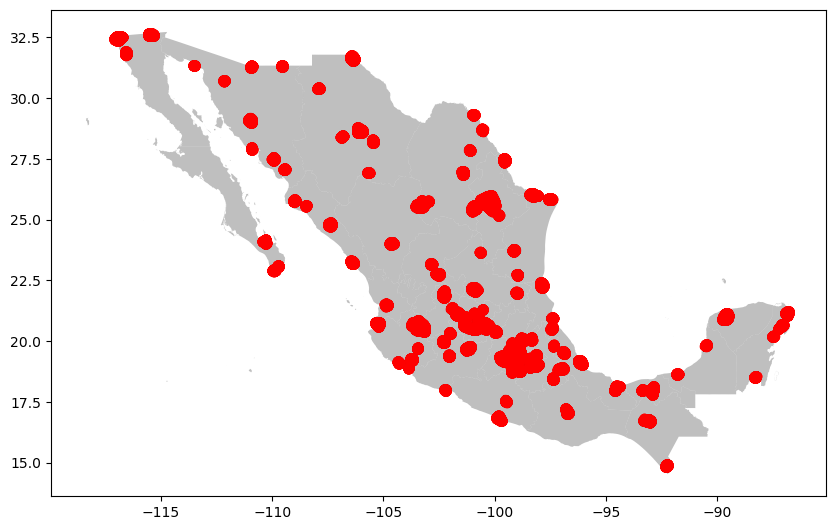

In [6]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot mexico but without boundries
gdf_mex_states.plot(ax=ax, color="gray", alpha=0.5)

# add hexagons
gdf_terrain_prices.plot(ax=ax, color="red", alpha=0.5)

# show
plt.show()

### Cities

In [7]:
# read cities
gdf_cities = gpd.read_parquet("../../data/misc/cities.parquet")

# crs to 4326
gdf_cities = gdf_cities.to_crs(epsg=4326)

# look
print(gdf_cities.shape)
gdf_cities.head()

(114, 3)


,geometry,cluster,total_properties
0,"POLYGON ((-89.76357 20.87249, -89.76472 20.872...",0,49294
1,"POLYGON ((-106.03177 28.56706, -106.03275 28.5...",1,41078
2,"POLYGON ((-106.36144 31.51678, -106.36259 31.5...",2,49914
3,"POLYGON ((-90.53583 19.79132, -90.53673 19.791...",3,4945
4,"POLYGON ((-100.08829 25.34193, -100.08904 25.3...",4,224732


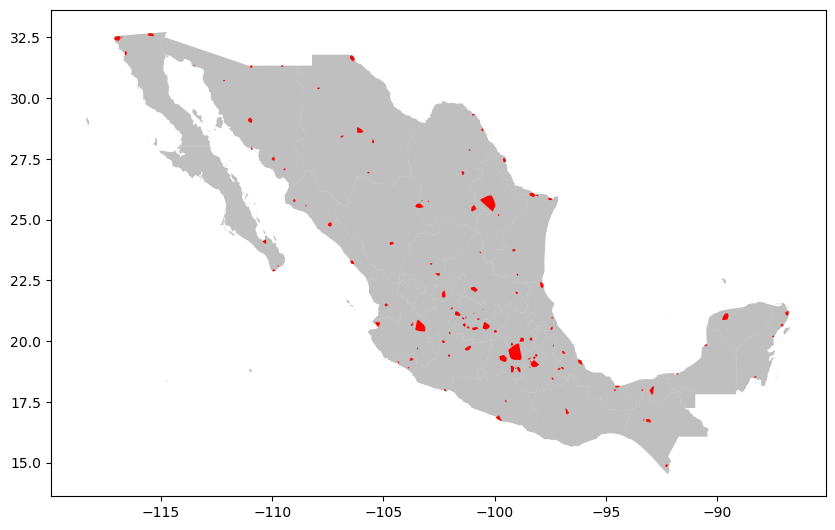

In [8]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot mexico but without boundries
gdf_mex_states.plot(ax=ax, color="gray", alpha=0.5)

# add hexagons
gdf_cities.plot(ax=ax, color="red")

# show
plt.show()

## Wrangle

In [9]:
# spatial join between terrains and cities
gdf_terrain_prices = (
    gdf_terrain_prices
    .sjoin(
        gdf_cities, 
        how="left", 
        predicate="intersects"
    )
    .drop(columns="index_right")
)

# look
print(gdf_terrain_prices.shape)
gdf_terrain_prices.head()

(261712, 9)


,hex_id,mean_log_valor_fisico_terreno_m2,std_log_valor_fisico_terreno_m2,city_cluster,latitude,longitude,geometry,cluster,total_properties
0,89450984803ffff,6.616558,0.382850,0,20.920002,-89.554488,POINT (-89.55449 20.92000),0.0,49294.0
1,89450984807ffff,6.627822,0.372650,0,20.922102,-89.557015,POINT (-89.55702 20.92210),0.0,49294.0
2,8945098480bffff,6.585862,0.349393,0,20.921128,-89.551302,POINT (-89.55130 20.92113),0.0,49294.0
3,8945098480fffff,6.616438,0.380885,0,20.923228,-89.553829,POINT (-89.55383 20.92323),0.0,49294.0
4,89450984813ffff,6.624113,0.377989,0,20.916777,-89.555146,POINT (-89.55515 20.91678),0.0,49294.0


---
# Graph2Vec

## S1: Get krings for each hex

In [10]:
# function to get neighbors at ring of size K
def get_neighbors(hex_id, K):
    return list(h3.hex_ring(hex_id, K))

# get neighbors and explode into a DataFrame
df_hex_neighbors = (
    gdf_terrain_prices[["hex_id"]]
    .assign(neighbors=lambda df: df["hex_id"].apply(get_neighbors, K=1))
    .explode("neighbors")
    .rename(columns={"hex_id": "hex_center_id", "neighbors": "hex_neighbor_id"})
    .reset_index(drop=True)
    .set_index(["hex_center_id"])
)

# look
df_hex_neighbors

,hex_neighbor_id
hex_center_id,
89450984803ffff,89450984813ffff
89450984803ffff,89450984817ffff
89450984803ffff,8945098480fffff
89450984803ffff,8945098481bffff
89450984803ffff,89450984807ffff
...,...
896d2a8dbb7ffff,896d2a8d97bffff
896d2a8dbb7ffff,896d2a8d96bffff
896d2a8dbb7ffff,896d2a8dbb3ffff


In [11]:
np.isclose(df_hex_neighbors.shape[0] / 6, gdf_terrain_prices.shape[0])

True

In [12]:
# unnique hex_center_id
df_hex_neighbors.index.nunique()

261712

## S2: Create Graph

In [13]:
# edges
edges = [
    (center, neighbor)
    for center, neighbor in tqdm(df_hex_neighbors.itertuples())
]

# look edges
edges[:5]

1570272it [00:00, 1788856.17it/s]


[('89450984803ffff', '89450984813ffff'),
 ('89450984803ffff', '89450984817ffff'),
 ('89450984803ffff', '8945098480fffff'),
 ('89450984803ffff', '8945098481bffff'),
 ('89450984803ffff', '89450984807ffff')]

In [14]:
# create graph
G = nx.Graph()
G.add_edges_from(edges)

# Check the graph structure
print(f"Number of nodes: {G.number_of_nodes()}, Number of edges: {G.number_of_edges()}")

Number of nodes: 280541, Number of edges: 803623


Some Hex IDs in the Neighbor Column Don’t Exist in the Main Column

## S3: Train Graph2Vec

In [15]:
# Define Node2Vec model
node2vec = Node2Vec(G, dimensions=16, walk_length=10, num_walks=10, workers=4)

# Fit model
model = node2vec.fit(window=5, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/280541 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Generating walks (CPU: 4): 100%|██████████| 2/2 [00:40<00:00, 20.40s/it]


In [16]:
# Get embeddings
df_hex_embeddings = pd.DataFrame({hex_id: model.wv[hex_id] for hex_id in G.nodes}).T

# rename columns
df_hex_embeddings.columns = [f"hex_embedding_{i+1}" for i in range(df_hex_embeddings.shape[1])]

df_hex_embeddings

,hex_embedding_1,hex_embedding_2,hex_embedding_3,hex_embedding_4,hex_embedding_5,hex_embedding_6,hex_embedding_7,hex_embedding_8,hex_embedding_9,hex_embedding_10,hex_embedding_11,hex_embedding_12,hex_embedding_13,hex_embedding_14,hex_embedding_15,hex_embedding_16
89450984803ffff,0.707565,-2.332074,-1.067359,1.942875,0.516474,-0.095697,1.086955,-0.575012,-0.188551,-1.708277,-0.625059,-0.181480,0.551151,1.642269,0.505332,1.325786
89450984813ffff,0.769511,-2.309926,-1.520424,1.990831,0.327063,-0.025649,1.182718,-0.874668,-0.190750,-1.298821,-0.644125,0.082719,0.378616,1.358415,0.702210,0.876324
89450984817ffff,0.763325,-2.224777,-1.442932,2.322895,0.437791,0.250621,1.535869,-0.689735,-0.154677,-1.674655,-0.552350,0.260767,0.644945,1.434781,0.584225,1.161779
8945098480fffff,0.763988,-2.347617,-0.621319,1.620347,0.837618,-0.203858,0.953181,-0.267314,-0.305507,-1.688940,-0.554231,-0.518550,0.428798,1.906759,0.389092,1.523091
8945098481bffff,0.802841,-2.563923,-1.135051,1.569627,0.475762,-0.414496,0.814337,-0.856905,-0.326692,-1.465625,-0.717987,-0.326153,0.260769,1.804890,0.519636,1.088404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896d2a8de6fffff,0.314934,-0.142120,0.164515,0.831023,1.296371,-0.215767,0.010431,-0.434652,-1.523757,-0.729077,-1.986532,0.507543,-1.108229,-0.117992,-1.245588,-0.894190
896d2a8de67ffff,0.268569,-0.073853,0.193553,0.723231,1.124575,-0.207478,0.008749,-0.357842,-1.227497,-0.739481,-1.743591,0.307346,-0.921710,-0.179529,-1.015475,-0.802568
896d2a8dac3ffff,0.605861,-0.175067,0.358063,0.360112,1.505262,-0.345072,0.098288,-0.620727,-1.525364,-0.571215,-2.341554,0.519509,-1.330858,-0.226455,-1.812189,-0.861158
896d2a8dad3ffff,0.300478,-0.128521,0.127189,0.550964,0.985912,-0.293948,0.102307,-0.292478,-1.210244,-0.489187,-1.617968,0.416455,-0.911255,-0.142308,-1.128190,-0.724042


In [17]:
# join embeddings to df_terrain_prices
cols_of_embeddings = df_hex_embeddings.filter(like="hex_embedding").columns.tolist()

gdf_terrain_prices_v2 = (
    gdf_terrain_prices
    .merge(
        df_hex_embeddings.reset_index().rename(columns={"index": "hex_id"}),
        how="inner",
        on="hex_id"
    )
    .loc[:, ["hex_id"] + cols_of_embeddings]
)

# look
print(gdf_terrain_prices_v2.shape)
gdf_terrain_prices_v2.head()

(261712, 17)


,hex_id,hex_embedding_1,hex_embedding_2,hex_embedding_3,hex_embedding_4,hex_embedding_5,hex_embedding_6,hex_embedding_7,hex_embedding_8,hex_embedding_9,hex_embedding_10,hex_embedding_11,hex_embedding_12,hex_embedding_13,hex_embedding_14,hex_embedding_15,hex_embedding_16
0,89450984803ffff,0.707565,-2.332074,-1.067359,1.942875,0.516474,-0.095697,1.086955,-0.575012,-0.188551,-1.708277,-0.625059,-0.181480,0.551151,1.642269,0.505332,1.325786
1,89450984807ffff,0.790538,-2.008472,-0.886281,1.824797,0.677695,0.189744,1.412594,-0.390504,-0.116900,-1.438850,-0.324970,-0.205234,0.663546,1.489596,0.471456,1.316030
2,8945098480bffff,0.810873,-2.685445,-0.874208,1.640909,0.753725,-0.459433,0.699501,-0.493449,-0.407070,-1.768724,-0.745195,-0.493471,0.444231,1.936955,0.272481,1.401079
3,8945098480fffff,0.763988,-2.347617,-0.621319,1.620347,0.837618,-0.203858,0.953181,-0.267314,-0.305507,-1.688940,-0.554231,-0.518550,0.428798,1.906759,0.389092,1.523091
4,89450984813ffff,0.769511,-2.309926,-1.520424,1.990831,0.327063,-0.025649,1.182718,-0.874668,-0.190750,-1.298821,-0.644125,0.082719,0.378616,1.358415,0.702210,0.876324


---
# Save

In [18]:
# save embeddings
gdf_terrain_prices_v2.to_parquet("../../data/misc/hex_embeddings.parquet")

In [19]:
# save model
model.save("../../models/hex2vec.model")

**Load full model**
model = Word2Vec.load("node2vec_model.model")


**Load just the word vectors**

from gensim.models import KeyedVectors

model_wv = KeyedVectors.load_word2vec_format("hex_embeddings.bin", binary=True)

**Get the embedding for a hex ID**

hex_id = "8928308280fffff"  # Example hex ID

embedding = model.wv[hex_id]

print(embedding)



---
# Sandbox

In [20]:
gdf_terrain_prices

,hex_id,mean_log_valor_fisico_terreno_m2,std_log_valor_fisico_terreno_m2,city_cluster,latitude,longitude,geometry,cluster,total_properties
0,89450984803ffff,6.616558,0.382850,0,20.920002,-89.554488,POINT (-89.55449 20.92000),0.0,49294.0
1,89450984807ffff,6.627822,0.372650,0,20.922102,-89.557015,POINT (-89.55702 20.92210),0.0,49294.0
2,8945098480bffff,6.585862,0.349393,0,20.921128,-89.551302,POINT (-89.55130 20.92113),0.0,49294.0
3,8945098480fffff,6.616438,0.380885,0,20.923228,-89.553829,POINT (-89.55383 20.92323),0.0,49294.0
4,89450984813ffff,6.624113,0.377989,0,20.916777,-89.555146,POINT (-89.55515 20.91678),0.0,49294.0
...,...,...,...,...,...,...,...,...,...
261707,896d2a8da9bffff,6.336306,0.498389,113,14.968453,-92.262609,POINT (-92.26261 14.96845),NaN,NaN
261708,896d2a8dac7ffff,6.496036,0.486523,113,14.964011,-92.266276,POINT (-92.26628 14.96401),NaN,NaN
261709,896d2a8dacfffff,6.489597,0.486504,113,14.962772,-92.269367,POINT (-92.26937 14.96277),NaN,NaN
261710,896d2a8dad7ffff,6.352893,0.497165,113,14.967214,-92.265700,POINT (-92.26570 14.96721),NaN,NaN


In [21]:
# duplicated in gdf_terrain_prices hex_id
gdf_terrain_prices['hex_id'].duplicated().sum()

0